In [1]:
from html import unescape
import psycopg2
from psycopg2.extras import RealDictCursor
import pandas as pd
import pandas.io.sql as sqlio
import html
from datasets import Dataset
import numpy as np
import matplotlib.pyplot as plt
from striprtf.striprtf import rtf_to_text
import re
from html import unescape
from time import time
import json

In [3]:
def get_data(limit=None, date='2020-01-01', params={"host":"192.168.40.12", "database":"test_capio2", "user":"xcare", "password":"xcare"}):
    query = f"""
            SELECT d.diagnostiknotat_id,
            string_agg(d2.diagnose_tekst, ';') as sks_beskrivelser,
            string_agg(d2.diagnose_kode, ';') as sks_koder,
            d.diagnostiknotat_tekst as journal_note
            FROM diagnostiknotat d
            JOIN fokus f USING (fokus_id)
            JOIN diagnose d2 USING (fokus_id)
            WHERE d2.diagnose_parent_id = 0
            AND d.diagnostiknotat_tidspunkt > '{date}'
            GROUP BY d.diagnostiknotat_id 
            """
    
    if limit is not None:
        query += f"limit {limit}"

    with psycopg2.connect(**params) as conn:
        res = sqlio.read_sql_query(query, conn)
    
    return res


def get_descriptions_from_file():
    with open("sks_code_descriptions.txt", "r") as f:
        descriptions = json.load(f)
    return descriptions


#def get_popular_sks_codes_from_file():
#    with open("popular_sks_codes.txt", "r") as f:
#        text = f.read()
#        popular_sks_codes = text.split(';')
#    return popular_sks_codes


def try_rtf_to_text (text_rtf):
    try:
        return rtf_to_text(text_rtf)
    except:
        return "Failure"

    
def get_sks_count(res):
    sks_count = {}
    sks2description = {}

    for sks_codes, sks_descriptions in zip(res.sks_koder, res.sks_beskrivelser):
        codes = sks_codes.split(';')
        descriptions = sks_descriptions.split(';')
        for code, description in zip(codes, descriptions):
            if code not in sks_count:
                sks_count[code] = 1
                sks2description[code] = description
            else:
                sks_count[code] += 1
    return dict(sorted(sks_count.items(), key=lambda x:x[1], reverse=True)), sks2description


class SksArrayConverter:
    
    def __init__(self, res, sks_count_threshold):
        #sks_count, self.sks2description_dict = get_sks_count(res)
        #self.popular_sks_codes = [key for key, val in sks_count.items() if val > sks_count_threshold]
        self.sks2description_dict = get_descriptions_from_file()
        self.popular_sks_codes = list(self.sks2description_dict.keys())
        
        self.limit = len(self.popular_sks_codes)
        
        self.idx2sks_dict = {idx:sks for idx, sks in enumerate(self.popular_sks_codes)}
        self.sks2idx_dict = {sks:idx for idx, sks in enumerate(self.popular_sks_codes)}
    
    def sks2idx(self, codes):
        array = np.zeros(self.limit, dtype=float)
        
        for sks in codes.split(';'):
            if sks not in self.sks2idx_dict:
                #print(f"{sks} is too unpopular!")
                continue
            array[self.sks2idx_dict[sks]] = 1.
        
        return array
    
    def idx2sks(self, array):
        sks_codes = [self.idx2sks_dict[idx] for idx, val in enumerate(array) if val]
        return ";".join(sks_codes)
    
    def idx2description(self, array):
        skss = self.idx2sks(array).split(';')
        descriptions = [self.sks2description_dict[sks] for sks in skss]
        return ";".join(descriptions)

    
def test_converter(converter):
    nbr_sks_codes = len(converter.popular_sks_codes)
    idxs = np.random.choice(nbr_sks_codes, size=min(nbr_sks_codes, 10), replace=False)
    idxs.sort()
    s = ";".join([converter.popular_sks_codes[idx] for idx in idxs])

    array = converter.sks2idx(s)
    string = converter.idx2sks(array)
    
    #print(f"{s}\n{array}\n{string}")
    if s == string:
        return
    else:
        print(f"{s}\n{array}\n{string}")
        raise Exception("FAILURE Converter doesn't work")
        
def preprocess(text):
    text = unescape(text)
    return re.sub(r'\n+', ' ', text)


# Combine into one function

In [7]:
def get_diagnostiknotat_data (limit=10000, sks_count_threshold=10, date='2020-01-01', verbose=1):
    
    def _print(foo):
        if verbose > 0:
            t1 = time()
            print(f"{foo} ({t1-t0:.1f}s)")
            return t1
        
    t0 = time()
    
    res = get_data(limit=limit, date=date)
    t0 = _print(f"{len(res)} rows fetched")
    
    #res.journal_note = res.journal_note.map(unescape)
    #res.journal_note = res.journal_note.map(lala)

    res['text'] = res.journal_note.map(preprocess)
    t0 = _print(f"Preprocessing")

    res.text = res.text.map(try_rtf_to_text)
    t0 = _print("Stripping rich text format")
    
    non_failure = res['text'] != "Failure"
    res = res[non_failure]
    t0 = _print(f"Removing {len(non_failure) - sum(non_failure)} of {len(non_failure)} rows ({(len(non_failure) - sum(non_failure)) / len(non_failure) * 100:.1f}%) where stripping failed")

    converter = SksArrayConverter(res, sks_count_threshold)
    t0 = _print(f"Predicting {len(converter.idx2sks_dict)} sks codes")
    test_converter(converter)

    res['labels'] = res.sks_koder.map(converter.sks2idx)
    t0 = _print("Converted sks codes to numpy arrays")

    non_zero = np.array([sum(row) for row in res['labels']]) != 0
    res = res[non_zero]
    t0 = _print(f"Removing {len(non_zero) - sum(non_zero)} of {len(non_zero)} empty rows ({(len(non_zero) - sum(non_zero)) / len(non_zero) * 100:.1f}%)")
    
    return Dataset.from_pandas(res), converter

/tmp/ipykernel_8125/848362686.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  res = sqlio.read_sql_query(query, conn)


,diagnostiknotat_id,sks_beskrivelser,sks_koder,journal_note,no_rtf,labels
0,1,Obs. pga mistanke om sygdom eller tilstand UNS...,DZ039;AAF21,{\rtf1\ansi\ansicpg0\uc1\deff0\deflang0\deflan...,"Selvhenvender, som kommer pga, at han har opda...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,12,Erhvervet hallux valgus;Førstegangsbesøg,DM201;AAF21,{\rtf1\ansi\ansicpg0\uc1\deff0\deflang0\deflan...,Henvist for højresidig hallux valgus til behan...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,13,Ekstremitetssmerter;Førstegangsbesøg,DM796;AAF21,{\rtf1\ansi\ansicpg0\uc1\deff0\deflang0\deflan...,Kommer til vurdering af smerter i venstre knæ ...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,14,Kolelitiasis UNS;UL-undersøgelse af øvre abdomen,DK802D;UXUD10,{\rtf1\ansi\ansicpg0\uc1\deff0\deflang0\deflan...,UL-skanning af øvre abdomen:\nLeveren med norm...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,15,Klinisk mammografi;Klinisk mammografi;Klinisk ...,UXRC40;UXRC40;ZZ0149;DZ016;UXUC40;UXUC40,{\rtf1\ansi\ansicpg0\uc1\deff0\deflang0\deflan...,Patienten er orienteret om strålerisici og acc...,"[1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...
9994,11062,Kontakt mhp radiologisk undersøgelse;MR-skanni...,DZ016;UXMA16,{\rtf1\ansi\ansicpg0\uc1\deff0\deflang0\deflan...,Patienten er informeret skriftligt og mundtlig...,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9995,11063,Kontakt mhp radiologisk undersøgelse;MR-skanni...,DZ016;UXME20,{\rtf1\ansi\ansicpg0\uc1\deff0\deflang0\deflan...,Patienten er informeret skriftligt og mundtlig...,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9997,11065,Blefarokalasi;Førstegangsbesøg,DH023;AAF21,{\rtf1\ansi\ansicpg0\uc1\deff0\deflang0\deflan...,Henvender sig mhp. operation for blefarokalase...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9998,11066,Uroflowmetri;Vandladningsbesvær UNS;Førstegang...,ZZ1280;DR391;AAF21;AFX01D1;UXUD75;UXUD92,{\rtf1\ansi\ansicpg0\uc1\deff0\deflang0\deflan...,68-årig mand stammende fra Kosovo henvist for ...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [22]:
"""
sks_count = {}
sks2description = {}

for sks_codes, sks_descriptions in zip(res.sks_koder, res.sks_beskrivelser):
    codes = sks_codes.split(';')
    descriptions = sks_descriptions.split(';')
    for code, description in zip(codes, descriptions):
        if code not in sks_count:
            sks_count[code] = 1
            sks2description[code] = description
        else:
            sks_count[code] += 1

j = dict(sorted(sks_count.items(), key=lambda x:x[1], reverse=True))

for sks in j.keys():
    print(f"{sks} - {sks2description[sks]}")
"""

### Examine how many (primary) diagnosis are on each journal note and fit to Poisson distribution


Text(0, 0.5, 'Relative difference (%)')

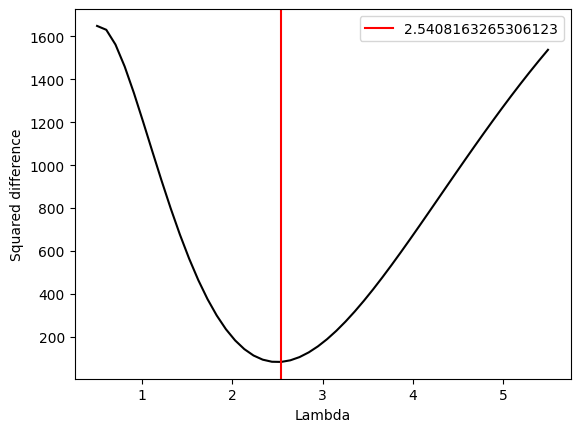

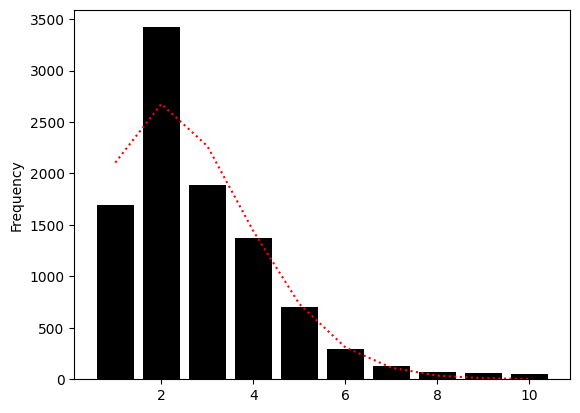

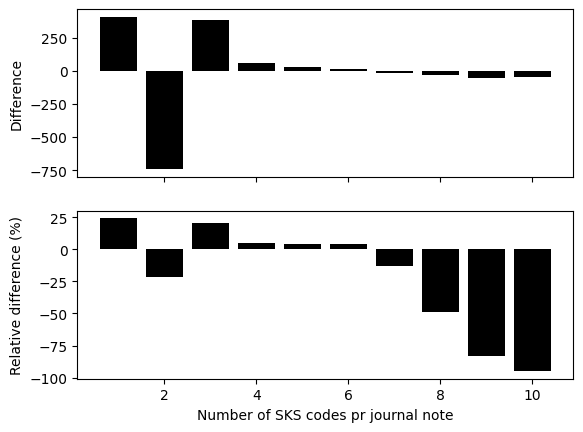

In [121]:
"""
Examine how many (primary) diagnosis are on each journal note
Fit to Poisson distribution
"""

from math import factorial as factorial_that_only_works_with_integers_this_is_dumb

def factorial(x):
    return np.array([factorial_that_only_works_with_integers_this_is_dumb(x_i) for x_i in x])

def poisson(x, l=2):
    x = x.astype(int)
    return l ** x * np.exp(-l) / factorial(x)

def plot_nbr_diagnoses():

    sums = np.array([sum(row) for row in res['labels']])

    y, x = np.histogram(sums, bins=int(sums.max()-sums.min()))

    x = x[:-1]

    def get_squared_diff(l):
        p = poisson(x, l=l)
        A = sum(y) / sum(p)
        p *= A

        #plt.plot(x, y, '.r')
        #plt.plot(x, p, '.b')

        sd = sum((y - p)**2)
        return sd / A

    l_ax = np.linspace(0.5, 5.5)
    sd_ax = [get_squared_diff(l) for l in l_ax]
    idx = np.argmin(sd_ax)

    plt.plot(l_ax, sd_ax, '-k')
    plt.axvline(l_ax[idx], color='red', label=str(l_ax[idx]))
    plt.xlabel("Lambda")
    plt.ylabel("Squared difference")
    plt.legend()

    p = poisson(x, l=l_ax[idx])
    A = sum(y) / sum(p)

    fig, ax0 = plt.subplots(1, 1)

    ax0.bar(x, y, color='black')
    ax0.plot(x, p*A, ':r')
    ax0.set_ylabel("Frequency")



    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

    ax1.bar(x, p*A - y, color='black')
    ax1.set_ylabel("Difference")

    ax2.bar(x, (p*A - y) / y * 100, color='black')
    ax2.set_xlabel("Number of SKS codes pr journal note")
    ax2.set_ylabel("Relative difference (%)")

In [75]:
import psycopg2
from psycopg2.extras import RealDictCursor
from striprtf.striprtf import rtf_to_text

def get_treatments(batch_size=2):

    params = {"host":"192.168.40.12", "database":"test_capio2", "user":"xcare", "password":"xcare"}

    query = f"""SELECT d.diagnostiknotat_id,
                string_agg(d2.diagnose_tekst, ';') as sks_beskrivelser,
                string_agg(d2.diagnose_kode, ';') as sks_koder,
                d.diagnostiknotat_tekst as journal_note
                FROM diagnostiknotat d
                JOIN fokus f USING (fokus_id)
                JOIN diagnose d2 USING (fokus_id)
                WHERE d2.diagnose_parent_id = 0
                AND d.diagnostiknotat_tidspunkt > '2023-01-01'
                GROUP BY d.diagnostiknotat_id 
            """.replace('\n', '')

    with psycopg2.connect(**params) as conn:

        with conn.cursor(cursor_factory=RealDictCursor) as cursor:

            cursor.execute(query)
            successes=0
            errors=0
            error_dict={}
            

            while True:
                batch = cursor.fetchmany(batch_size)
                if not batch:
                    break

                for row in batch:
                    try:
                        text = rtf_to_text(row['journal_note'])
                        successes += 1
                        
                        yield text
                    # except Exception as e:
                    except (UnicodeDecodeError, UnicodeEncodeError) as e:
                        # e = str(exc)
                        if e.reason in error_dict:
                            error_dict[e.reason] += 1
                        else:
                            error_dict[e.reason] = 1
                        errors = sum(error_dict.values())
                    if (successes + errors) % 5000 == 0:
                        print(f"Iterated {successes + errors} notes, {errors} errors")
    for k, v in error_dict.items():
        print(" * ", k, v)
    print(f"Found {successes + errors} lines (errors in {errors} lines | {errors / (successes + errors) * 100:.1f}% of data)")

def get_treatments_2(batch_size=2):

    params = {"host":"192.168.40.12", "database":"test_capio2", "user":"xcare", "password":"xcare"}

    query = f"""SELECT d.diagnostiknotat_id,
                string_agg(d2.diagnose_tekst, ';') as sks_beskrivelser,
                string_agg(d2.diagnose_kode, ';') as sks_koder,
                d.diagnostiknotat_tekst as journal_note
                FROM diagnostiknotat d
                JOIN fokus f USING (fokus_id)
                JOIN diagnose d2 USING (fokus_id)
                WHERE d2.diagnose_parent_id = 0
                AND d.diagnostiknotat_tidspunkt > '2023-01-01'
                GROUP BY d.diagnostiknotat_id 
            """.replace('\n', '')

    query = f"""ELECT count(*)
                FROM booking_suggested_time bst 
                WHERE bst.created >= '2023-10-16 12:55:28'
                AND bst.created <= '2024-1-20 14:42:29'
            """.replace('\n', '')    
    


    with psycopg2.connect(**params) as conn:

        with conn.cursor(cursor_factory=RealDictCursor) as cursor:

            cursor.execute(query)
            successes=0
            errors=0
            error_dict={}
            

            while True:
                batch = cursor.fetchmany(batch_size)
                if not batch:
                    break

                for row in batch:
                    try:
                        text = rtf_to_text(row['journal_note'])
                        successes += 1
                        
                        yield text
                    # except Exception as e:
                    except (UnicodeDecodeError, UnicodeEncodeError) as e:
                        # e = str(exc)
                        if e.reason in error_dict:
                            error_dict[e.reason] += 1
                        else:
                            error_dict[e.reason] = 1
                        errors = sum(error_dict.values())
                    if (successes + errors) % 5000 == 0:
                        print(f"Iterated {successes + errors} notes, {errors} errors")
    for k, v in error_dict.items():
        print(" * ", k, v)
    print(f"Found {successes + errors} lines (errors in {errors} lines | {errors / (successes + errors) * 100:.1f}% of data)")
